In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import torch

from hysteresis.linear_bayesian import BayesianLinearizedHysteresis
from hysteresis.linearized import LinearizedHysteresis
from hysteresis.training import train_bayes, map_bayes

calculated 25 states


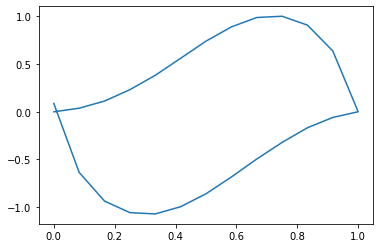

In [2]:
fname = '../../facet_ii_data/quadrupoles/quad_m1-34.ru1'
data = []
with open(fname,'r') as f:
    f.readline()
    for line in f:
        temp = line.rstrip().split(' ')
        d = []
        for ele in temp:
            if ele != '':
                d += [ele]
        data += [d]
data = np.asfarray(data)
data[:, 1] = data[:, 1]
data[:, 3] = data[:, 3] * np.where(data[:,7] < 0, -1, 1)

# get real h, m
h_full = torch.tensor(data[:,1]).double()
m_full = torch.tensor(data[:,3]).double()

h = torch.tensor(data[:,1]).double()
m = torch.tensor(data[:,3]).double()

H = LinearizedHysteresis(h, m, mesh_scale=0.5, trainable=False)

hl = H.transformer.transform_h(h)
ml = H.transformer.transform_m(m, h)

plt.plot(hl, ml)


In [3]:
from hysteresis.bayesian import positional_covariance

def cov(model):
    return positional_covariance(model, 1.0)

# Do SVI estimate w/o correlations
B = BayesianLinearizedHysteresis(H)
guide, loss = train_bayes(h, ml, B, 10000, initial_lr=0.001)

[iteration 0001] loss: 429776.8021
[iteration 0101] loss: 418450.1185
[iteration 0201] loss: 224903.6902
[iteration 0301] loss: 547432.5342
[iteration 0401] loss: 251423.8387
[iteration 0501] loss: 138951.2222
[iteration 0601] loss: 123338.7108
[iteration 0701] loss: 45807.5489
[iteration 0801] loss: 246517.6832
[iteration 0901] loss: 120807.9053
[iteration 1001] loss: 60730.2864
[iteration 1101] loss: 25188.5163
[iteration 1201] loss: 141672.2633
[iteration 1301] loss: 51691.7613
[iteration 1401] loss: 12602.6940
[iteration 1501] loss: 71188.2860
[iteration 1601] loss: 16925.4061
[iteration 1701] loss: 48644.4602
[iteration 1801] loss: 20460.8211
[iteration 1901] loss: 10390.4354
[iteration 2001] loss: 46745.8449
[iteration 2101] loss: 51456.4009
[iteration 2201] loss: 7567.2278
[iteration 2301] loss: 45445.2997
[iteration 2401] loss: 15137.0839
[iteration 2501] loss: 4223.1292
[iteration 2601] loss: 20862.8770
[iteration 2701] loss: 13912.4947
[iteration 2801] loss: 12035.1214
[itera

calculated 19 states


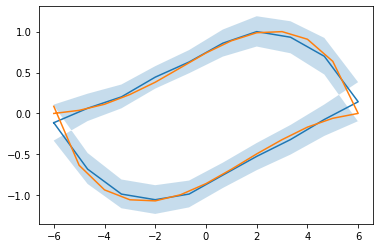

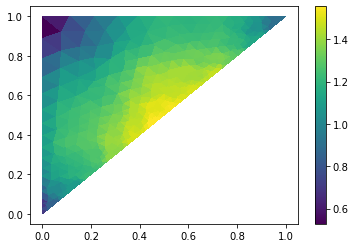

In [7]:
# make predictions
from hysteresis.bayesian_utils import predict
from hysteresis.visualization import plot_hysteresis_density

t = torch.linspace(0, 1, 10)
h_test = torch.cat((t, t.flipud()))
h_test = H.unnormalize_h(h_test)
pred_summary, samples = predict(h_test, B, guide)
mean = pred_summary['obs']['mean']
upper = pred_summary['obs']['95%']
lower = pred_summary['obs']['5%']

plt.plot(h_test, mean)
plt.fill_between(h_test, lower, upper, alpha=0.25)
plt.plot(h, ml)

dens = torch.nn.Softplus()(pred_summary['density']['mean'].detach().flatten())
fig,ax = plot_hysteresis_density(H, dens)

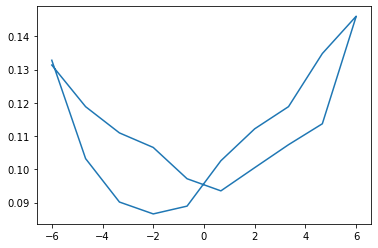

In [11]:
plt.plot(h_test, pred_summary['obs']['std'])


In [8]:
import pyro
#for name, item in pyro.get_param_store().items():
#    print(f'{name}:{item}')